# Questions - Lab Session I

### 1-Make the following Changes On the Streamlit app

__a__ - Use 'sample' instead of 'head' in the streamlit app. The app must be stable after you select the patient from the patient list
<br>
__b__ - Modify the app by adding a button. The app should bring the raw features if the user click the button instead of default loading.
<br>
__c__ - Create a slider as age. The slider can be slided between 15 to 100 interval. When you slide it the selected patient's age variable must be changed with slided value and the calculations must be updated with the new input.



### 2- Modify the FastApi app

__a__ Create an input model by using pydantic datamodels. You are free to implement your own datamodel up to your taste, feel free to try Enum, str, int whatever you like.
<br>
__b__ Define a default value for the race column as 'Other'. If the user gives doesn't provide the information the API must set it as 'Other'
<br>
__c__ Define a response body including Score, Class and runtime informations 

# Imports

In [1]:
import io
import requests
import zipfile
import re
import os
import copy
import numpy as np
import pandas as pd
from pyarrow import parquet as pq
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# Getting the Data

In [3]:
zip_file_url = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip'

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./")

# Import Data

## From CSV

In [4]:
%%time

df = pd.read_csv('./diabetic_data.csv')

CPU times: total: 250 ms
Wall time: 470 ms


## From parquet by using pyarrow

In [5]:
df.to_parquet('./diabetes.pq')

del df # redundant

In [6]:
%%time

df = pq.read_table('./diabetes.pq').to_pandas()

CPU times: total: 250 ms
Wall time: 333 ms


In [7]:
pq.read_table('./diabetes.pq')

pyarrow.Table
encounter_id: int64
patient_nbr: int64
race: string
gender: string
age: string
weight: string
admission_type_id: int64
discharge_disposition_id: int64
admission_source_id: int64
time_in_hospital: int64
payer_code: string
medical_specialty: string
num_lab_procedures: int64
num_procedures: int64
num_medications: int64
number_outpatient: int64
number_emergency: int64
number_inpatient: int64
diag_1: string
diag_2: string
diag_3: string
number_diagnoses: int64
max_glu_serum: string
A1Cresult: string
metformin: string
repaglinide: string
nateglinide: string
chlorpropamide: string
glimepiride: string
acetohexamide: string
glipizide: string
glyburide: string
tolbutamide: string
pioglitazone: string
rosiglitazone: string
acarbose: string
miglitol: string
troglitazone: string
tolazamide: string
examide: string
citoglipton: string
insulin: string
glyburide-metformin: string
glipizide-metformin: string
glimepiride-pioglitazone: string
metformin-rosiglitazone: string
metformin-pioglit

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df.readmitted.isnull().sum()

0

No null value, dropna parameter is redundant.

In [10]:
df.readmitted.value_counts()

readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

We want to target as **readmitted or not** independent from time period.

In [11]:
d = {
    'NO': 0, 
    '>30': 1, 
    '<30': 1
}

df['readmitted'] = df['readmitted'].map(d)
df.readmitted.value_counts()

readmitted
0    54864
1    46902
Name: count, dtype: int64

In [12]:
df = df.rename(columns=lambda name: re.sub('\W', '_', name.strip()).lower())

In [13]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,1
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0


# Data Wrangling

In [14]:
# added max_glu_serum and a1cresult because otherwise 'None' entries in them were intrepreted as null,
# which causes contradiction with the outputs
df[['encounter_id', 'patient_nbr', 'max_glu_serum', 'a1cresult']] = df[['encounter_id', 'patient_nbr', 'max_glu_serum', 'a1cresult']].astype(str)

In [15]:
df = df.replace({'?': np.nan})

In [16]:
# Checking for the null values
nulls_info = (df.isnull().sum()/len(df) * 100).sort_values(ascending=False)
nulls_info.head()

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
dtype: float64

First 3 entry must be examined.

In [17]:
vars_to_examine = ['weight', 'medical_specialty', 'payer_code']
df_tmp = copy.deepcopy(df[vars_to_examine + ['readmitted']])
df_tmp = df_tmp.applymap(lambda x: 'None' if x is np.nan else x)

for col in vars_to_examine:
    tmp = df_tmp.groupby(col).agg({'readmitted': ['mean', 'std']})
    tmp.columns = tmp.columns.droplevel(0)
    print(tmp.sort_values('mean'))

               mean       std
weight                       
None       0.456888  0.498140
[25-50)    0.515464  0.502357
[150-175)  0.542857  0.505433
[175-200)  0.545455  0.522233
[50-75)    0.550725  0.497698
[125-150)  0.558621  0.498273
[100-125)  0.574400  0.494830
[75-100)   0.610778  0.487756
[0-25)     0.812500  0.394443
>200       1.000000  0.000000
                                          mean       std
medical_specialty                                       
Psychiatry-Addictive                  0.000000       NaN
Perinatology                          0.000000       NaN
Proctology                            0.000000       NaN
Neurophysiology                       0.000000       NaN
Speech                                0.000000       NaN
Pediatrics-Endocrinology              0.150943  0.359125
Obstetrics                            0.157895  0.374634
DCPTEAM                               0.166667  0.408248
Gynecology                            0.172414  0.381039
Obstetricsand

Here, we see that the 'None' group we have created has mixed mean values for medical_specialty and payer_code features. But for weight feature, mean value for 'None' group covers a different part of the data, which means those nulls are informative. So, we will keep this column and flag the null values with '?'.

In [18]:
df = df.drop(columns=['medical_specialty', 'payer_code'])
df = df.fillna({'weight': '?'})

In [19]:
dummy_variables = ['race', 'gender', 'weight', 'admission_source_id', 'admission_type_id', 'discharge_disposition_id']
binary_columns = ['change', 'diabetesmed']

In [20]:
for col in binary_columns + dummy_variables:
    print(f"{col}: {sum(pd.isnull(df[col]))}")

change: 0
diabetesmed: 0
race: 2273
gender: 0
weight: 0
admission_source_id: 0
admission_type_id: 0
discharge_disposition_id: 0


Converting ordinal categorics to numeric

In [21]:
df.age.value_counts()

age
[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: count, dtype: int64

In [22]:
d = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25, 
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55, 
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85, 
    '[90-100)': 95
}

df['age'] = df['age'].map(d)
df['age']

0          5
1         15
2         25
3         35
4         45
          ..
101761    75
101762    85
101763    75
101764    85
101765    75
Name: age, Length: 101766, dtype: int64

In [23]:
df.max_glu_serum.value_counts()

max_glu_serum
None    96420
Norm     2597
>200     1485
>300     1264
Name: count, dtype: int64

In [24]:
d = {
    'None': 0, 
    'Norm': 1, 
    '>200': 2, 
    '>300': 3
}

df['max_glu_serum'] = df['max_glu_serum'].map(d)
df['max_glu_serum']

0         0
1         0
2         0
3         0
4         0
         ..
101761    0
101762    0
101763    0
101764    0
101765    0
Name: max_glu_serum, Length: 101766, dtype: int64

In [25]:
df.a1cresult.value_counts()

a1cresult
None    84748
>8       8216
Norm     4990
>7       3812
Name: count, dtype: int64

In [26]:
d = {
    'None': 0, 
    'Norm': 1, 
    '>7': 2, 
    '>8': 3
}

df['a1cresult'] = df['a1cresult'].map(d)
df['a1cresult']

0         0
1         0
2         0
3         0
4         0
         ..
101761    3
101762    0
101763    0
101764    0
101765    0
Name: a1cresult, Length: 101766, dtype: int64

In [27]:
df.race.value_counts(dropna=False)

race
Caucasian          76099
AfricanAmerican    19210
NaN                 2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

In [28]:
known_patients = df[~pd.isnull(df.race)][['patient_nbr', 'race']].drop_duplicates()
known_patients.groupby('patient_nbr').count().sort_values('race', ascending=False).head()

,race
patient_nbr,
107849052,3
106895331,3
98962209,2
561609,2
83158605,2


For example, examine the '561609':

In [29]:
df[df.patient_nbr == '561609'].race

12669    Caucasian
20723     Hispanic
Name: race, dtype: object

Let's create an imputer for race column

In [30]:
print(f"The number of nulls on the race column before this step is: {sum(pd.isnull(df.race))}")

known_patients_n_races = known_patients.groupby('patient_nbr').count()

invalid_patient_nbr = list(known_patients_n_races[known_patients_n_races.race != 1].index)
known_patients = known_patients[~known_patients.patient_nbr.isin(invalid_patient_nbr)]

assert known_patients.shape[0] == known_patients.drop_duplicates(subset='patient_nbr').shape[0], 'Duplicates in patient_nbr'

df = pd.merge(df, known_patients, how='left', on='patient_nbr')

df['race'] = df['race_x'].combine_first(df['race_y'])
df = df.drop(columns=['race_x', 'race_y'])

print(f"The number of nulls on the race column after this step is: {sum(pd.isnull(df.race))}")

The number of nulls on the race column before this step is: 2273
The number of nulls on the race column after this step is: 2130


For imputation, we should pick columns that may create a fitting pattern to explain the race

In [31]:
cols_for_imputation = ['gender', 'age', 'weight']
cols_for_imputation = [col for col in df.columns for dummy_root in cols_for_imputation if dummy_root in col]
df[cols_for_imputation].dtypes

gender    object
age        int64
weight    object
dtype: object

In [32]:
df['weight'].value_counts()

weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64

In [33]:
df[cols_for_imputation].head()

,gender,age,weight
0,Female,5,?
1,Female,15,?
2,Female,25,?
3,Male,35,?
4,Male,45,?


What done under here is basically:
- Creating *x_train_race* and *y_train_race* where race is not null. These will be used for imputation.
- Creating *x_test_race* where 'race' is null. This data will be used to predict the missing 'race' values once the imputation model is trained.
- Since 'Caucasian' is overrepresented, undersampling it.
- Combining them to achieve y_train_race.
- Updating x_train_race to only include the entries corresponding to y_train_race.

In [34]:
x_train_race = df[~pd.isnull(df.race)][cols_for_imputation]
y_train_race = df[~pd.isnull(df.race)]['race']
x_test_race = df[pd.isnull(df.race)][cols_for_imputation]

# We shall apply undersampling to balance the categorical levels
y_train_race_1 = y_train_race[y_train_race != 'Caucasian']
y_train_race_2 = y_train_race[y_train_race == 'Caucasian']
y_train_race_2 = y_train_race_2.sample(n=20000)

y_train_race = pd.concat([y_train_race_1, y_train_race_2])
x_train_race = x_train_race.loc[y_train_race.index]
y_train_race.value_counts()

race
Caucasian          20000
AfricanAmerican    19223
Hispanic            2047
Other               1513
Asian                641
Name: count, dtype: int64

In [35]:
race_imputer = CatBoostClassifier(max_depth=3, 
                                  random_seed=10)

race_imputer.fit(x_train_race, 
                 y_train_race,
                 cat_features=['gender','weight'],
                 verbose=250
             )

y_test_race = race_imputer.predict(x_test_race)
y_test_race

Learning rate set to 0.095906
0:	learn: 1.5063152	total: 201ms	remaining: 3m 21s
250:	learn: 1.0008005	total: 14.4s	remaining: 43s
500:	learn: 0.9990593	total: 29.3s	remaining: 29.2s
750:	learn: 0.9976491	total: 43.4s	remaining: 14.4s
999:	learn: 0.9965248	total: 57.3s	remaining: 0us


array([['Caucasian'],
       ['AfricanAmerican'],
       ['Caucasian'],
       ...,
       ['Caucasian'],
       ['AfricanAmerican'],
       ['Caucasian']], dtype=object)

In [36]:
%%time

os.mkdir('./artifacts')
race_imputer.save_model('./artifacts/imputer_model.cbm')

CPU times: total: 0 ns
Wall time: 5.48 ms


In [37]:
df.loc[df.race.isna(), 'race'] = race_imputer.predict(df.loc[df.race.isna(), race_imputer.feature_names_])
df.race.value_counts(dropna=False)

race
Caucasian          77514
AfricanAmerican    20049
Hispanic            2047
Other               1515
Asian                641
Name: count, dtype: int64

There are bad values for numeric columns diag_1, diag_2, diag_3:

In [38]:
df[['diag_1', 'diag_2', 'diag_3']].head()

,diag_1,diag_2,diag_3
0,250.83,NaN,NaN
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250


In [39]:
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].applymap(lambda x: float(re.sub('\D', '', x)) 
                                                                                 if isinstance(x, str) else x)

In [40]:
df[['diag_1', 'diag_2', 'diag_3']].isnull().sum()

diag_1      21
diag_2     358
diag_3    1423
dtype: int64

In [41]:
df[['diag_1', 'diag_2', 'diag_3']].head()

,diag_1,diag_2,diag_3
0,25083.0,NaN,NaN
1,276.0,25001.0,255.0
2,648.0,250.0,27.0
3,8.0,25043.0,403.0
4,197.0,157.0,250.0


Making ID columns string.

In [42]:
df[['admission_type_id',
    'discharge_disposition_id',
    'admission_source_id']]= df[['admission_type_id','discharge_disposition_id','admission_source_id']].astype('str')

# Modeling

In [43]:
target = 'readmitted'
not_input = ['readmitted', 'patient_nbr', 'encounter_id']
input_features = [column for column in df.columns if column not in not_input]
cat_features = list(df[input_features].select_dtypes(include='object').columns)

In [44]:
df.readmitted.value_counts(dropna=False) / df.shape[0]

readmitted
0    0.539119
1    0.460881
Name: count, dtype: float64

In [45]:
y = df.readmitted
X = df[input_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.8, 
                                                    stratify = y,
                                                    random_state = 10)

In [46]:
pool_train = Pool(data = X_train,
                 label = y_train,
                 cat_features = cat_features)

pool_test =  Pool(data = X_test,
                 label = y_test,
                 cat_features = cat_features)

In [47]:
model = CatBoostClassifier(max_depth=5,
                         random_state=1,
                         eval_metric='Accuracy'
                         )

In [48]:
model.fit(pool_train,
          use_best_model=True,
          verbose=100,
          eval_set=pool_test)

Learning rate set to 0.09394
0:	learn: 0.6217142	test: 0.6303921	best: 0.6303921 (0)	total: 146ms	remaining: 2m 25s
100:	learn: 0.6453840	test: 0.6480299	best: 0.6486686 (87)	total: 16.2s	remaining: 2m 24s
200:	learn: 0.6544367	test: 0.6505847	best: 0.6509777 (186)	total: 31.4s	remaining: 2m 4s
300:	learn: 0.6601852	test: 0.6517147	best: 0.6522060 (282)	total: 46.5s	remaining: 1m 47s
400:	learn: 0.6647177	test: 0.6514690	best: 0.6527955 (322)	total: 1m 1s	remaining: 1m 31s
500:	learn: 0.6677394	test: 0.6523042	best: 0.6527955 (322)	total: 1m 16s	remaining: 1m 16s
600:	learn: 0.6697661	test: 0.6533360	best: 0.6533851 (567)	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.6731563	test: 0.6540238	best: 0.6548590 (653)	total: 1m 47s	remaining: 45.8s
800:	learn: 0.6760060	test: 0.6543186	best: 0.6548590 (653)	total: 2m 3s	remaining: 30.6s
900:	learn: 0.6784995	test: 0.6544168	best: 0.6552520 (876)	total: 2m 18s	remaining: 15.3s
999:	learn: 0.6808210	test: 0.6535325	best: 0.6552520 (876)	total: 

# Save Model and the Data

In [49]:
%%time

df.drop_duplicates(subset='patient_nbr', keep='last').to_parquet('./artifacts/demo_data.pq')
model.save_model('./artifacts/scoring_model.cbm')

CPU times: total: 234 ms
Wall time: 399 ms


In [50]:
model.save_model('./scoring_model.pmml')

In [51]:
import shap

c:\Users\Bora\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


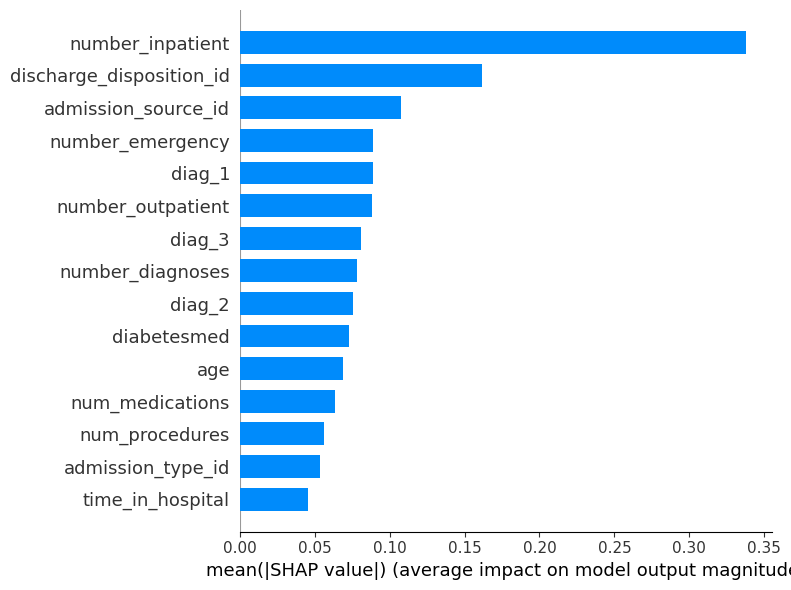

In [52]:
exp = shap.TreeExplainer(model)
vals = exp.shap_values(X_test[model.feature_names_])

shap.summary_plot(vals,
                  X_test[model.feature_names_],
                  max_display= 15,
                  plot_type='bar',
                  plot_size=.3)

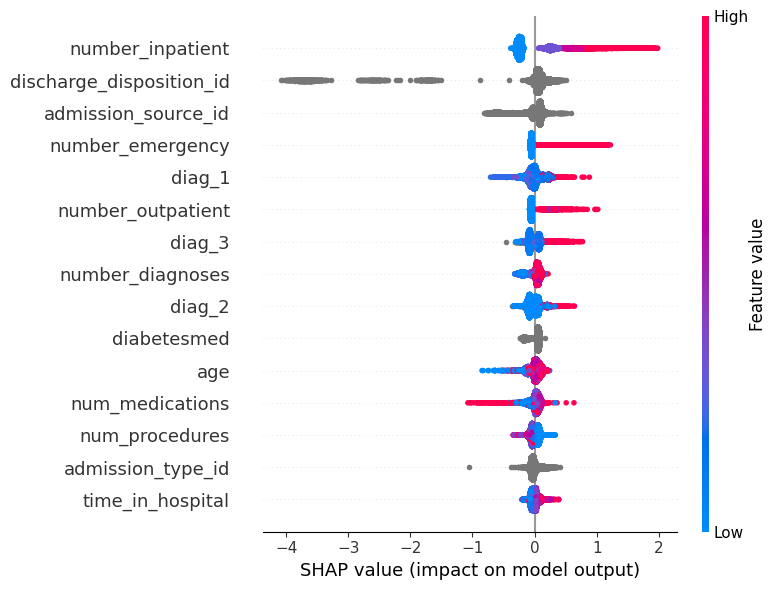

In [53]:
shap.summary_plot(vals,
                  X_test[model.feature_names_],
                  max_display= 15,
                  plot_type='dot',
                  plot_size=.3)

In [54]:
X_test.head(1)

,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,race
8163,Female,85,?,6,1,7,3,49,0,8,...,No,No,No,No,No,No,No,No,No,Caucasian


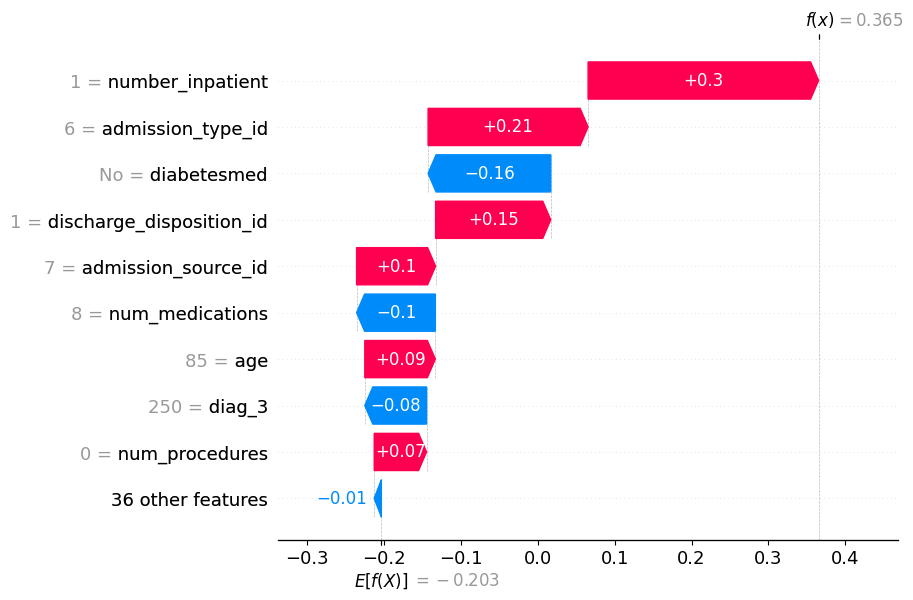

In [55]:
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test.head(1))

plt.figure(figsize=(10, 10))

fig = shap.plots.waterfall(shap_values[0], max_display=10)
plt.show()